In [1]:
import findspark
findspark.init()

In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors
from pyspark.sql.types import IntegerType
import warnings
warnings.filterwarnings("ignore")

In [3]:
spark = SparkSession.builder.appName('HomeLoan').getOrCreate()

# <font color='Mediumblue'>Table Contents</font> </br>

<details>
    <summary>Click for details</summary>


1. [Overview about data](#overview) <br/> <br />

2. [Pre-process data](#preprocess) <br /> <br />

    2.1. [Handle Null and NaN values](#NullNaN)
 
     > *[Fill Null values with mode values function](#func1) 
    
    2.2. [Handle outlier](#outliers)
            
    2.3. [Prepare data for model](#data)
<br>

3. [Building model](#model)

    3.1. [Split data](#split)
    
    3.2. [Logistic regression](#logistic)
    
    3.3. [Decision Tree Classifier](#tree)

<br> 

4. [Prediction with new data](#predict)

    4.1 [New data](#new)
    
    4.2 [Process new data](#modeled)
    
    4.3 [Prediction and result](#result)
    
</details>

## <a name="overview">Overview about data</a>

In [4]:
data = spark.read.csv("HomeLoan/loan_sanction_train.csv", inferSchema = True, header = True)

In [5]:
data.printSchema()

root
 |-- Loan_ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Self_Employed: string (nullable = true)
 |-- ApplicantIncome: integer (nullable = true)
 |-- CoapplicantIncome: double (nullable = true)
 |-- LoanAmount: integer (nullable = true)
 |-- Loan_Amount_Term: integer (nullable = true)
 |-- Credit_History: integer (nullable = true)
 |-- Property_Area: string (nullable = true)
 |-- Loan_Status: string (nullable = true)



| No | Variable          | Type                   | Description                                     |
|----|-------------------|------------------------|-------------------------------------------------|
| 1  | Loan_ID           | Numerical - Discrete   | Unique Loan ID                                  |
| 2  | Gender            | Categorical - Nominal  | Male / Female                                   |
| 3  | Married           | Categorical - Nominal  | Applicant married (Y/N)                         |
| 4  | Dependents        | Categorical - Ordinal  | Number of dependents (0, 1, 2, 3+)              |
| 5  | Education         | Categorical - Nominal  | Applicant Education (Graduate / Under Graduate) |
| 6  | Self_Employed     | Categorical - Nominal  | Self employed (Y/N)                             |
| 7  | ApplicantIncome   | Numerical - Continuous | Applicant income                                |
| 8  | CoapplicantIncome | Numerical - Continuous | Coapplicant income                              |
| 9  | LoanAmount        | Numerical - Continuous | Loan amount in thousands                        |
| 10 | Loan_Amount_Term  | Numerical - Discrete   | Term of loan in months                          |
| 11 | Credit_History    | Categorical - Nominal  | credit history meets guidelines (0, 1)          |
| 12 | Property_Area     | Categorical - Ordinal  | Urban / Semi Urban / Rural                      |
| 13 | Loan_Status       | Categorical - Nominal  | Loan approved (Y/N)                             |

In [6]:
data.count()

614

In [7]:
data.show(5)

+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
| Loan_ID|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|Loan_Status|
+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-----------+
|LP001002|  Male|     No|         0|    Graduate|           No|           5849|              0.0|      NULL|             360|             1|        Urban|          Y|
|LP001003|  Male|    Yes|         1|    Graduate|           No|           4583|           1508.0|       128|             360|             1|        Rural|          N|
|LP001005|  Male|    Yes|         0|    Graduate|          Yes|           3000|              0.0|        66|             360|             1|        Urban|          Y

In [8]:
data.groupBy("Loan_Status").count().show()

+-----------+-----+
|Loan_Status|count|
+-----------+-----+
|          Y|  422|
|          N|  192|
+-----------+-----+



<b>Note:</b> The loan of 422 (around 69%) people out of 614 was approved. There is no imbalanced classes issue in this dataset, thus accuracy as an evaluation metric should be appropriate.

In [9]:
plot_data = data.toPandas()

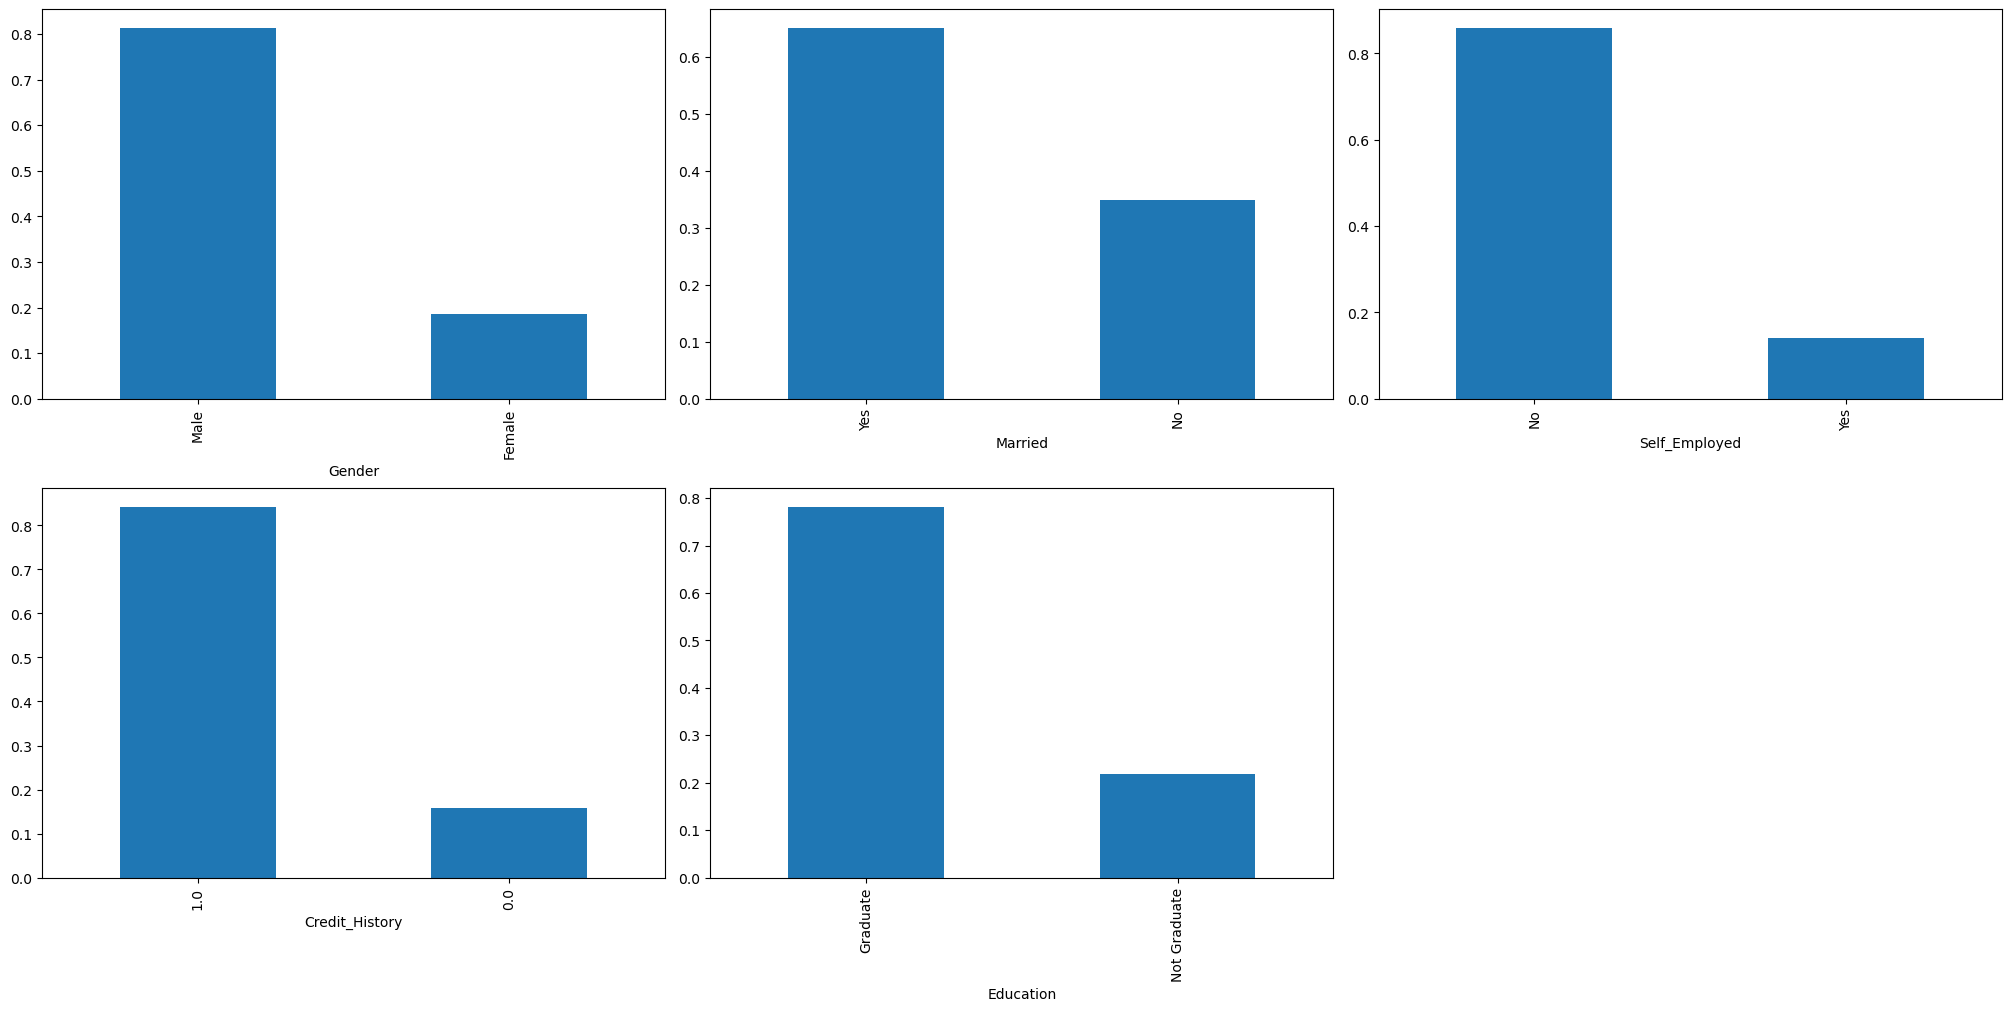

In [10]:
plt.figure(figsize = (20, 10), layout= 'constrained')

plt.subplot(231)
plot_data['Gender'].value_counts(normalize = True).plot.bar()

plt.subplot(232)
plot_data['Married'].value_counts(normalize = True).plot.bar()

plt.subplot(233)
plot_data['Self_Employed'].value_counts(normalize = True).plot.bar()

plt.subplot(234)
plot_data['Credit_History'].value_counts(normalize = True).plot.bar()

plt.subplot(235)
plot_data['Education'].value_counts(normalize = True).plot.bar()

plt.show()

<ul>  
    <li>  80% applicants in the dataset are male.
    <li>Around 65% of the applicants in the dataset are married.</li>
    <li>Around 15% applicants in the dataset are self employed.</li>
    <li>Around 85% applicants have credit history (repaid their debts).</li>
    <li>Around 80% of the applicants are Graduate.</li>
</ul>

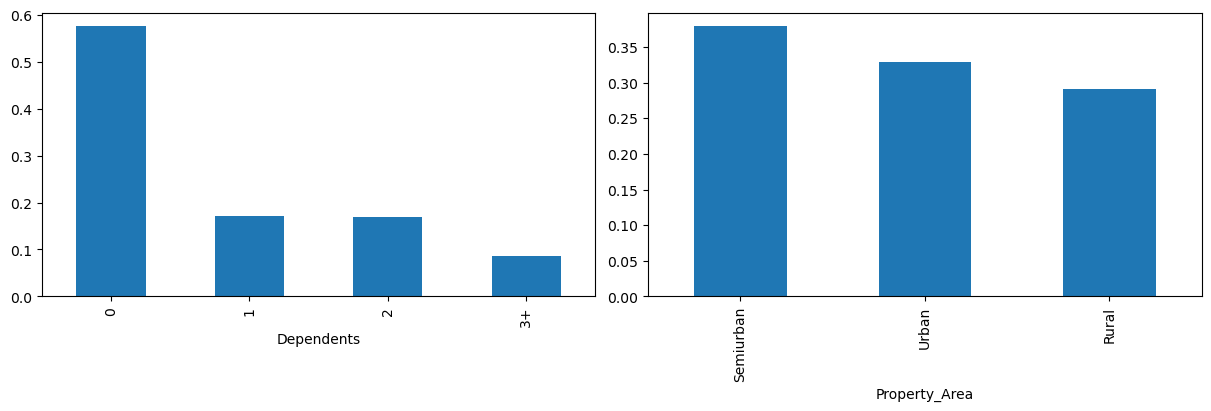

In [11]:
plt.figure(figsize = (12, 4), layout= 'constrained')

plt.subplot(121)
plot_data['Dependents'].value_counts(normalize=True).plot.bar()

plt.subplot(122)
plot_data['Property_Area'].value_counts(normalize=True).plot.bar()

plt.show()

<b>Note:</b> 
    <li>More than half of the applicants don’t have any dependents.</li>
    <li>Most of the applicants are from Semiurban area.</li>

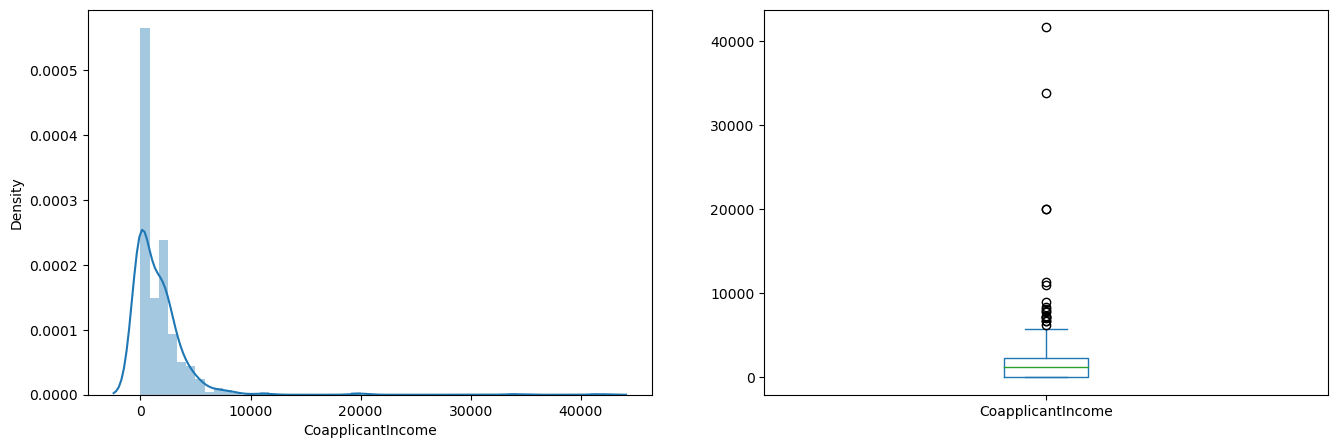

In [12]:
plt.subplot(121)
sns.distplot(plot_data['CoapplicantIncome']);

plt.subplot(122)
plot_data['CoapplicantIncome'].plot.box(figsize=(16,5))

plt.show()

<b>Note:</b> Majority of coapplicant’s income ranges from 0 to 5000, a lot of outliers in the coapplicant income and it is not normally distributed.

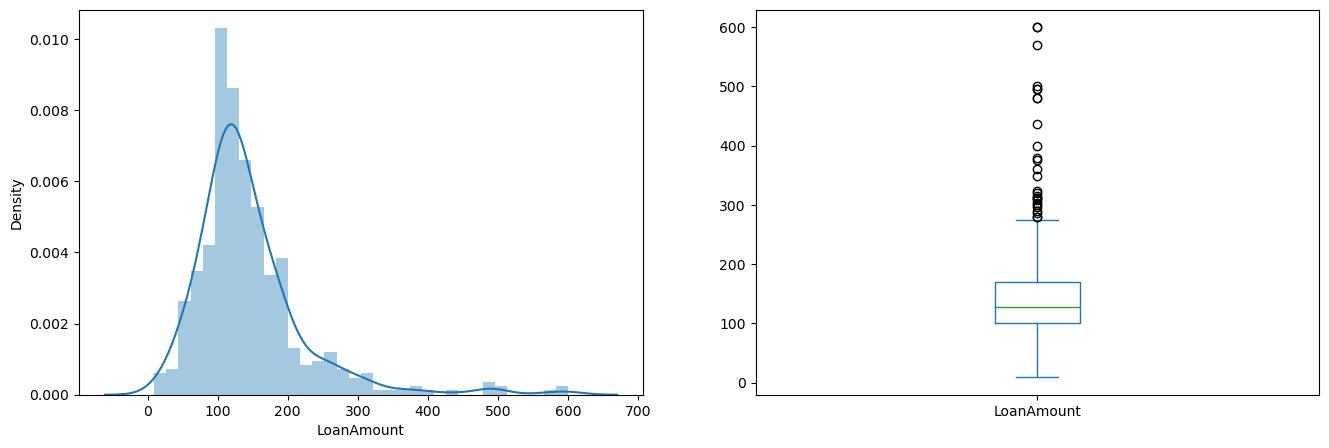

In [13]:
plt.subplot(121)
plot_data = plot_data.dropna()
sns.distplot(plot_data['LoanAmount']);

plt.subplot(122)
plot_data['LoanAmount'].plot.box(figsize=(16,5))

plt.show()

<b>A fairly normal distribution (albeit still slightly right-skewed) for LoanAmount but there are lot of outliers in this variable. I will treat the outliers in later sections.</b>

## <a name="preprocess">Pre-process data</a>

### <a name="NullNaN">Handle Null and NaN values</a>

In [14]:
data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).toPandas().T

,0
Loan_ID,0
Gender,13
Married,3
Dependents,15
Education,0
Self_Employed,32
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,22
Loan_Amount_Term,14


In [15]:
data.select([count(when(isnan(col(c)), c)).alias(c) for c in data.columns]).toPandas().T

,0
Loan_ID,0
Gender,0
Married,0
Dependents,0
Education,0
Self_Employed,0
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,0
Loan_Amount_Term,0


There are missing values in Gender, Married, Dependents, Self_Employed, LoanAmount, Loan_Amount_Term and Credit_History features. We will treat the missing values in all the features one by one.

Use these methods to fill the missing values:

<ul>
<li>For numerical variables: imputation using mean or median</li>
<li>For categorical variables: imputation using mode</li>
</ul>

There are <b>very less</b> missing values in Gender, Married, Dependents, Credit_History and Self_Employed features so I will fill them using the mode of the features.

#### <a name="func1">Fill Null values with mode values function</a>

In [16]:
def fill_Mode(data, cols: list):
    '''This fucntion return the dictonary contain the mode value of each column
    Params:
        data: the pyspark dataFrame
        cols: list of columns
    return: data fill NaN with mode values
    '''
    for column in cols:
        df1 = data.where(col(column).isNotNull())
        df1.registerTempTable('table')
        
        query = '''SELECT {}, COUNT({}) AS count FROM table 
        GROUP BY {} ORDER BY count desc'''
        
        df2 = spark.sql(query.format(column, column, column))
        
        data = data.fillna({column: df2.first()[column]})
        
    return data

In [17]:
fill_col = ['Gender', 'Married', 'Dependents', 
            'Self_Employed', 'Credit_History', 'Loan_Amount_Term']

data = fill_Mode(data, fill_col)

<b>Now let check the LoanAmount variable. As it is a numerical variable, we can use mean or median to impute the missing values. I will use median to fill the null values as earlier loan amount have outliers so the mean value will not be the proper value as it is highly affected by the presence of outliers.</b>

In [18]:
median_value = data.select(median(data.LoanAmount)).collect()[0][0]
data = data.fillna({"LoanAmount": median_value})

<b>Check null again</b>

In [19]:
data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).toPandas().T

,0
Loan_ID,0
Gender,0
Married,0
Dependents,0
Education,0
Self_Employed,0
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,0
Loan_Amount_Term,0


### <a name="outliers">Handle outliers</a>

As I note in the Overview data that the LoanAmount is fairly normal distribution (albeit still slightly right-skewed) because of the outliers so to deal with this problem, I use the log transformation. <br>

The log transformation does not effect the small value but reduce the large value -> so with this the LoanAmount will have the normal distribuiton

In [20]:
data = data.withColumn('LoanAmount', log(col('LoanAmount')))

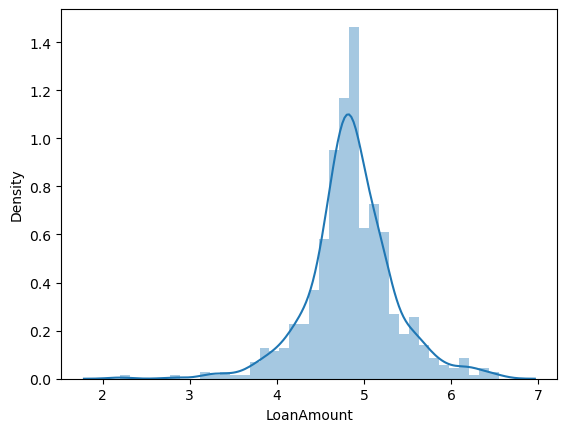

In [21]:
#check again
temp = data.select("LoanAmount").toPandas()
sns.distplot(temp['LoanAmount']);

<b>Now the distribution looks much closer to normal and effect of extreme values has been significantly subsided.</b>

### <a name="data">Prepare data for model</a>

In [22]:
#drop unnecessary column
data = data.drop("Loan_ID")

In [23]:
# Change 3+ in Dependents column, cast string to Integer

data = data.withColumn("Dependents", when(col("Dependents") == '3+', '3')
                                     .otherwise(col("Dependents")))
data = data.withColumn("Dependents", data["Dependents"].cast(IntegerType()))

In [24]:
# Change the LoanStatus from Y-N to 1-0
data = data.withColumn("Loan_Status", when(col("Loan_Status") == "Y", 1)
                                      .when(col("Loan_Status") == "N", 0))
data = data.withColumn("Loan_Status", data["Loan_Status"].cast(IntegerType()))

In [25]:
data.printSchema()

root
 |-- Gender: string (nullable = false)
 |-- Married: string (nullable = false)
 |-- Dependents: integer (nullable = true)
 |-- Education: string (nullable = true)
 |-- Self_Employed: string (nullable = false)
 |-- ApplicantIncome: integer (nullable = true)
 |-- CoapplicantIncome: double (nullable = true)
 |-- LoanAmount: double (nullable = true)
 |-- Loan_Amount_Term: integer (nullable = false)
 |-- Credit_History: integer (nullable = false)
 |-- Property_Area: string (nullable = true)
 |-- Loan_Status: integer (nullable = true)



In [26]:
# String indexer and OneHotEncoder for some columns
indexer1 = StringIndexer(inputCol = 'Gender', outputCol = 'Gender_idx')
indexer2 = StringIndexer(inputCol = 'Married', outputCol = 'Married_idx')
indexer3 = StringIndexer(inputCol = 'Education', outputCol = 'Education_idx')
indexer4 = StringIndexer(inputCol = 'Self_Employed', outputCol = 'Self_Employed_idx')
indexer5 = StringIndexer(inputCol = 'Property_Area', outputCol = 'Property_Area_idx')

encoder = OneHotEncoder(inputCols = ['Gender_idx', 'Married_idx', 'Education_idx', 
                                     'Self_Employed_idx', 'Property_Area_idx', 'Dependents'],
                        outputCols = ['Gender_en', 'Married_en', 'Education_en', 
                                     'Self_Employed_en', 'Property_Area_en', 'Dependents_en'])

pipeline = Pipeline(stages = [indexer1, indexer2, indexer3, indexer4, indexer5, encoder])
indexer_data = pipeline.fit(data).transform(data)

In [27]:
indexer_data.printSchema()

root
 |-- Gender: string (nullable = false)
 |-- Married: string (nullable = false)
 |-- Dependents: integer (nullable = true)
 |-- Education: string (nullable = true)
 |-- Self_Employed: string (nullable = false)
 |-- ApplicantIncome: integer (nullable = true)
 |-- CoapplicantIncome: double (nullable = true)
 |-- LoanAmount: double (nullable = true)
 |-- Loan_Amount_Term: integer (nullable = false)
 |-- Credit_History: integer (nullable = false)
 |-- Property_Area: string (nullable = true)
 |-- Loan_Status: integer (nullable = true)
 |-- Gender_idx: double (nullable = false)
 |-- Married_idx: double (nullable = false)
 |-- Education_idx: double (nullable = false)
 |-- Self_Employed_idx: double (nullable = false)
 |-- Property_Area_idx: double (nullable = false)
 |-- Gender_en: vector (nullable = true)
 |-- Married_en: vector (nullable = true)
 |-- Education_en: vector (nullable = true)
 |-- Self_Employed_en: vector (nullable = true)
 |-- Property_Area_en: vector (nullable = true)
 |--

In [28]:
assembler = VectorAssembler(inputCols = ['Gender_en', 'Married_en', 'Education_en', 
                                         'Self_Employed_en', 'Property_Area_en',
                                        'ApplicantIncome', 'CoapplicantIncome', 'Dependents_en', 
                                        'LoanAmount', 'Loan_Amount_Term', 'Credit_History'],
                            outputCol = 'features')
final_data = assembler.transform(indexer_data)

In [29]:
final_data = final_data.select('features', 'Loan_Status')
final_data.show(5)

+--------------------+-----------+
|            features|Loan_Status|
+--------------------+-----------+
|[1.0,0.0,1.0,1.0,...|          1|
|[1.0,1.0,1.0,1.0,...|          0|
|[1.0,1.0,1.0,0.0,...|          1|
|[1.0,1.0,0.0,1.0,...|          1|
|[1.0,0.0,1.0,1.0,...|          1|
+--------------------+-----------+
only showing top 5 rows



## <a name="model">Building model</a>

### <a name="split">Split data</a>

In [30]:
train_data, test_data = final_data.randomSplit([0.7, 0.3], seed = 42)

In [31]:
train_data.describe().show()

+-------+-------------------+
|summary|        Loan_Status|
+-------+-------------------+
|  count|                456|
|   mean| 0.7039473684210527|
| stddev|0.45701586943577416|
|    min|                  0|
|    max|                  1|
+-------+-------------------+



In [32]:
test_data.describe().show()

+-------+------------------+
|summary|       Loan_Status|
+-------+------------------+
|  count|               158|
|   mean|0.6392405063291139|
| stddev|0.4817478055556703|
|    min|                 0|
|    max|                 1|
+-------+------------------+



### <a name="logistic">Logistic regression</a>

In [33]:
lr = LogisticRegression(featuresCol = "features",
                        labelCol = "Loan_Status",
                        predictionCol = "Predict Loan_Status",
                        family = 'binomial', )
lrModel = lr.fit(train_data)

In [34]:
test_model = lrModel.transform(test_data)
prediction = test_model.select("Loan_Status", "Predict Loan_Status")
prediction.show(5)

+-----------+-------------------+
|Loan_Status|Predict Loan_Status|
+-----------+-------------------+
|          0|                0.0|
|          1|                1.0|
|          1|                1.0|
|          0|                0.0|
|          1|                1.0|
+-----------+-------------------+
only showing top 5 rows



In [35]:
eval_accuracy = MulticlassClassificationEvaluator(labelCol = "Loan_Status", 
                                                  predictionCol = "Predict Loan_Status", 
                                                  metricName = "accuracy")

eval_auc = BinaryClassificationEvaluator(labelCol = "Loan_Status", 
                                         rawPredictionCol = "Predict Loan_Status")

print("Accuracy: {}".format(eval_accuracy.evaluate(test_model)))
print("AUC: {}".format(eval_auc.evaluate(test_model)))

Accuracy: 0.8164556962025317
AUC: 0.7494354698627758


So our predictions are over 81% accurate, i.e. we have identified 81% of the loan status correctly.
<br>The AUC > 0.7 -> the model seem good. Let's check the precision and recall.

In [36]:
evaluator = MulticlassClassificationEvaluator(predictionCol = "Predict Loan_Status",
                                              labelCol = "Loan_Status")

In [37]:
precision = evaluator.evaluate(test_model, {evaluator.metricName: "precisionByLabel",
                                             evaluator.metricLabel: 1.0})
precision

0.78125

In [38]:
recall = evaluator.evaluate(test_model, {evaluator.metricName: "recallByLabel",
                                             evaluator.metricLabel: 1.0})
recall

0.9900990099009901

<b>The performance of our model seems encouraging, with accuracy of 81%, precision of 78% and recall of 99%.</b>

### <a name="tree">Decision Tree Classifier</a>

In [39]:
dct = DecisionTreeClassifier(featuresCol = 'features',
                             labelCol = 'Loan_Status',
                             predictionCol = 'Predict Loan_Status', maxDepth = 4)
dctModel = dct.fit(train_data)

In [40]:
test_tree = dctModel.transform(test_data)
pre_tree = test_tree.select("Loan_Status", "Predict Loan_Status")
pre_tree.show(5)

+-----------+-------------------+
|Loan_Status|Predict Loan_Status|
+-----------+-------------------+
|          0|                0.0|
|          1|                1.0|
|          1|                1.0|
|          0|                0.0|
|          1|                1.0|
+-----------+-------------------+
only showing top 5 rows



In [41]:
eval_accuracy = MulticlassClassificationEvaluator(labelCol = "Loan_Status", 
                                                  predictionCol = "Predict Loan_Status", 
                                                  metricName = "accuracy")

eval_auc = BinaryClassificationEvaluator(labelCol = "Loan_Status", 
                                         rawPredictionCol = "Predict Loan_Status")

print("Accuracy: {}".format(eval_accuracy.evaluate(test_tree)))
print("AUC: {}".format(eval_auc.evaluate(test_tree)))

Accuracy: 0.8037974683544303
AUC: 0.7357130449887094


In [42]:
evaluator = MulticlassClassificationEvaluator(predictionCol = "Predict Loan_Status",
                                              labelCol = "Loan_Status")

In [43]:
precision = evaluator.evaluate(test_tree, {evaluator.metricName: "precisionByLabel",
                                             evaluator.metricLabel: 1.0})
precision

0.7734375

In [44]:
recall = evaluator.evaluate(test_tree, {evaluator.metricName: "recallByLabel",
                                             evaluator.metricLabel: 1.0})
recall

0.9801980198019802

<b>Note:</b> I can see that these two model has nearly the same accuarcy, precision and recall so choose one of them is ok

## <a name="predict">Prediction with new data</a>

### <a name="new">New data</a>

In [45]:
new_data = spark.read.csv("HomeLoan/loan_sanction_test.csv", inferSchema = True, header = True)

In [46]:
new_data.printSchema()

root
 |-- Loan_ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Self_Employed: string (nullable = true)
 |-- ApplicantIncome: integer (nullable = true)
 |-- CoapplicantIncome: integer (nullable = true)
 |-- LoanAmount: integer (nullable = true)
 |-- Loan_Amount_Term: integer (nullable = true)
 |-- Credit_History: integer (nullable = true)
 |-- Property_Area: string (nullable = true)



### <a name="modeled">Process new data</a>

In [47]:
new_data.select([count(when(col(c).isNull(), c)).alias(c) for c in new_data.columns]).toPandas().T

,0
Loan_ID,0
Gender,11
Married,0
Dependents,10
Education,0
Self_Employed,23
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,5
Loan_Amount_Term,6


In [48]:
fill_col = ['Gender','Dependents', 'Self_Employed', 
            'Credit_History', 'Loan_Amount_Term']

predict_data = fill_Mode(new_data, fill_col)

In [49]:
median_value = predict_data.select(median(predict_data.LoanAmount)).collect()[0][0]
predict_data = predict_data.fillna({"LoanAmount": median_value})

In [50]:
predict_data.select([count(when(col(c).isNull(), c)).alias(c) for c in predict_data.columns]).toPandas().T

,0
Loan_ID,0
Gender,0
Married,0
Dependents,0
Education,0
Self_Employed,0
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,0
Loan_Amount_Term,0


In [51]:
predict_data = predict_data.withColumn('LoanAmount', log(col('LoanAmount')))

In [52]:
predict_data = predict_data.withColumn("Dependents", when(col("Dependents") == '3+', '3')
                                             .otherwise(col("Dependents")))
predict_data = predict_data.withColumn("Dependents", predict_data["Dependents"].cast(IntegerType()))

In [53]:
predict_data = pipeline.fit(predict_data).transform(predict_data)

In [54]:
predict_data = assembler.transform(predict_data)

In [55]:
final_pre_data = predict_data.select("features")
final_pre_data.show(3)

+--------------------+
|            features|
+--------------------+
|[1.0,1.0,1.0,1.0,...|
|[1.0,1.0,1.0,1.0,...|
|[1.0,1.0,1.0,1.0,...|
+--------------------+
only showing top 3 rows



### <a name="result">Prediction and result</a>

In [56]:
result = lrModel.transform(final_pre_data)
result.select('features','Predict Loan_Status').show(5)

+--------------------+-------------------+
|            features|Predict Loan_Status|
+--------------------+-------------------+
|[1.0,1.0,1.0,1.0,...|                1.0|
|[1.0,1.0,1.0,1.0,...|                1.0|
|[1.0,1.0,1.0,1.0,...|                1.0|
|[1.0,1.0,1.0,1.0,...|                1.0|
|(14,[0,3,4,6,8,11...|                1.0|
+--------------------+-------------------+
only showing top 5 rows



In [57]:
result.show()

+--------------------+--------------------+--------------------+-------------------+
|            features|       rawPrediction|         probability|Predict Loan_Status|
+--------------------+--------------------+--------------------+-------------------+
|[1.0,1.0,1.0,1.0,...|[-2.2264098121338...|[0.09740382118160...|                1.0|
|[1.0,1.0,1.0,1.0,...|[-1.8773068382147...|[0.13269852202789...|                1.0|
|[1.0,1.0,1.0,1.0,...|[-2.1895452887196...|[0.10069326207241...|                1.0|
|[1.0,1.0,1.0,1.0,...|[-2.2339996304504...|[0.09673858821049...|                1.0|
|(14,[0,3,4,6,8,11...|[-1.4802144555326...|[0.18539502923710...|                1.0|
|[1.0,1.0,0.0,0.0,...|[-1.8725828136879...|[0.13324315223322...|                1.0|
|(14,[3,5,6,9,11,1...|[-0.5471035975865...|[0.36653665719259...|                1.0|
|(14,[0,1,3,6,10,1...|[2.27927414577829...|[0.90714592465379...|                0.0|
|[1.0,1.0,1.0,1.0,...|[-2.5552631061397...|[0.07207369991938...| 

In [58]:
final_result = predict_data.join(result, predict_data.features == result.features, "inner")

In [59]:
list_col = data.columns
list_col.remove("Loan_Status")
list_col.append("Predict Loan_Status")

In [60]:
final_result = final_result.select(list_col)
final_result.printSchema()

root
 |-- Gender: string (nullable = false)
 |-- Married: string (nullable = true)
 |-- Dependents: integer (nullable = true)
 |-- Education: string (nullable = true)
 |-- Self_Employed: string (nullable = false)
 |-- ApplicantIncome: integer (nullable = true)
 |-- CoapplicantIncome: integer (nullable = true)
 |-- LoanAmount: double (nullable = true)
 |-- Loan_Amount_Term: integer (nullable = false)
 |-- Credit_History: integer (nullable = false)
 |-- Property_Area: string (nullable = true)
 |-- Predict Loan_Status: double (nullable = false)



In [63]:
final_result.write.option("header",True).csv("HomeLoan/Result")